<code style="background:yellow;color:black"><b><u><font size="7">Section 1</font></u></b></code>

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imdb
import warnings
warnings.filterwarnings("ignore")

In [109]:
df=pd.read_csv('Comprehensive IMDb Data.csv')

<code style="background:yellow;color:black"><b><u><font size="6">** Filter True/Accutare Movie ID For Unique Movie Title:</font></u></b></code>

We need Movie ID (example: tt0081505) to extract or process different parameters, either from IMDB python API or other databases provided my IMDB itself.

But given Dataset has multiple Movie IDs agianst single movie, and only one of those multiple IDs is accurate/True Id for that specific movie. 

For example the movie Titanic has 7 different IDs, but only one of them is accurate. The other 6 IDs are of some Titanic mini film, documentary, some local version of short film name titanic, etc.

And the information against wrong Ids is incorrect in our dataset, for example for titanic short film (not the movie Titanic which we globally recognize) neither the actor is Leonardo DiCaprio nor the director is James Cameron, its rating is different from the original movie, and above all, we are not interested in these short films or documentaries.

In [110]:
# Removing 'tt' from 'titleId' to match it with IDs format provided by python API.
df['titleId'] = df['titleId'].map(lambda x: x.lstrip('tt'))

In [111]:
#Concatenate different attributes to get unique value in dataset for further processes.

 # year_title_star
 # year_title_primaryName
 # concatinate year_title 
 # result = year_title_star == year_title_primaryName (True or False)

df['year_title_star']=df["year"].astype(str) + "_" +df["title"].astype(str) + "_" + df["star"]
df['year_title_primaryName']=df["year"].astype(str) + "_" +df["title"].astype(str) + "_" + df["primaryName"]
df['year_title']=df["year"].astype(str) + "_" +df["title"].astype(str)

In [112]:
# we have star name in separate column against each move, we also have star name in primaryName (along other cast)
# so by filtering star in primary name will give us one unique row of infomration against that movie.
# it will return maximum unique values with true IDs.

df['result'] = np.where(df['year_title_star'] == df['year_title_primaryName'], 'True', 'False')
df=df[df['result'].isin(['True'])]
df.shape

(7272, 26)

In [113]:
# Chekc if we still have duplicate values in year_title 
print('Now, do we have any duplicate values in  Year_title ? =  ',df.duplicated(subset=['year_title']).any())
print('Total number of duplicates =  ', df.year_title.duplicated(keep=False).sum())

Now, do we have any duplicate values in  Year_title ? =   True
Total number of duplicates =   214


In [114]:
# lets treat above duplications now,
df['Y_T_Duplicate']=df.year_title.duplicated(keep=False)
fdf = df[df['Y_T_Duplicate']==True] # new dataframe with only duplicate entries to process separately.
df = df.loc[df['Y_T_Duplicate']==False ] # Drop true values from df as we will treat them in separate DF.

# make long IMBD title to get accurate ID from IMDB API.
fdf['long_title']=fdf['title'].astype(str) + " (" + fdf["year"].astype(str) + ")"

**below command will take a lot of time, depeding on your internet speed as we are prcessing IMDB API, and its very slow**

The only way to get true IDs agianst long IMDB title is by API, IMDB dont provide this in their other databases. we are pricessing this for only 214 values whihc we filer above as "Discrepancies".

In [115]:
# Copy correct ID in fdf['Y_T__T_ID'] form API

ia = imdb.IMDb()
fdf['Y_T__T_ID'] = fdf['long_title'].apply(lambda x: ia.search_movie(x)[0].movieID)

In [116]:
# now compare new ID with ID in DB
fdf['ID_vs_ID']=np.where(fdf['titleId'] == fdf['Y_T__T_ID'], True, False)

# Keep only True values
fdf=fdf.loc[fdf['ID_vs_ID']==True ]
fdf.shape

(105, 30)

In [117]:
#Reshape the filtered datframe to copy it to our main Dataframe
fdf=fdf[['titleId', 'title', 'rating', 'region', 'genre', 'released', 'year',
       'month', 'day', 'score', 'director', 'writer', 'star', 'country',
       'budget', 'gross', 'company', 'runtime', 'category', 'nconst',
       'primaryName', 'knownForTitles', 'year_title_star',
       'year_title_primaryName', 'year_title', 'result', 'Y_T_Duplicate']]

df=pd.concat([df,fdf])
df=df.drop(columns=['result','Y_T_Duplicate']) # We dont neet it any

In [118]:
# Chekc again if we still have duplicate values in year_title 
print('Now, do we have any duplicate values in  Year_title ? =  ',df.duplicated(subset=['year_title']).any())
print('Total number of duplicates =  ', df.year_title.duplicated(keep=False).sum())

Now, do we have any duplicate values in  Year_title ? =   False
Total number of duplicates =   0


In [119]:
# Drop unnecessary columns, as we dont have any Duplicate value now.
#df=df.drop(columns=['result','Y_T_Duplicate'])

# save this Dataframe to a CSV file, to load it directly and save (API) Run time next time.
df.to_csv('NB_1_result_IMDB_UniqueID_10Nov21.csv',index=False)

<code style="background:yellow;color:black"><b><u><font size="4">Now Our Data has unique movies, with true IDs,  so we can use this Dataframe or CSV for further  cleaning and extracting more information.</font></u></b></code>

In [120]:
df_IMDB=pd.read_csv('Comprehensive IMDb Data.csv') # given DB
df=pd.read_csv('NB_1_result_IMDB_UniqueID_10Nov21.csv') # results from Notebook 1 (True Movie ID)

print('Given IMDB database size = ',df_IMDB.shape)
print('CSV from Notebook 1, (Unique entries, True ID) size = ',df.shape)

Given IMDB database size =  (222569, 22)
CSV from Notebook 1, (Unique entries, True ID) size =  (7163, 25)


<code style="background:yellow;color:black"><b><u><font size="6">** FURTHER DATA EXTRACTION FROM OTHER IMDB DATABASES:</font></u></b></code>

<code style="background:yellow;color:black"><b><u><font size="4">> Extract upto three mian genres for each movie title.</font></u></b></code>

In [121]:
# Runtime 20Sec

# load tsv file to dataFrame (Database provided by IMDB)
title_basics=pd.read_csv("title.basics.tsv", sep='\t')

# remove tt from tconst and convert it to int, because ID is int type in our previous DF
title_basics['tconst'] = title_basics['tconst'].map(lambda x: x.lstrip('tt'))
title_basics['tconst']=title_basics['tconst'].apply(int) 

In [122]:
#####  Vlookup genrese from (above) name_basic to our main DataFrame

# **  Setp 1: Set ncost as index in boht dataframes (df and name_basics)
title_basics.set_index('tconst',inplace=True)
df.set_index('titleId',inplace=True)   #name_basics.reset_index(inplace=True)  ## Toremove index again

# ** Step 2:  make BLANK column name for geners to copy data in main df
df['3_genres']=""

# ** Setp 3: 
df['3_genres']=df.index.map(title_basics['genres'])

# ** Step 4: remove tconst and title is from index in boht dataFrames
title_basics.reset_index(inplace=True)
df.reset_index(inplace=True)

df[['titleId','title','3_genres']].head()

#df['3_genres'].str.get_dummies(sep=',')

,titleId,title,3_genres
0,81505,The Shining,"Drama,Horror"
1,80453,The Blue Lagoon,"Adventure,Drama,Romance"
2,80684,Star Wars: Episode V - The Empire Strikes Back,"Action,Adventure,Fantasy"
3,80339,Airplane!,Comedy
4,80487,Caddyshack,"Comedy,Sport"


<code style="background:yellow;color:black"><b><u><font size="4">> Convert countries to Continents</font></u></b></code>

In [123]:
# ****  Function to convert countries to continent

import pycountry_convert as pc
def country_to_continent(country_name):
    country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    return country_continent_name
# Function Refrence: https://www.buzzphp.com/posts/get-continent-name-from-country-using-pycountry

In [124]:
# **  process country column

# only one NaN in country column, and that too was wierd value so we can drop it for sure
df=df.dropna(subset=["country"]) 

# Ignoring movies form 'west germany' and 'Yugoslavia'. (Total = 12 movies [including one NaN country])
df.drop(index=df[df['country'] == 'West Germany'].index, inplace=True)
df.drop(index=df[df['country'] == 'Federal Republic of Yugoslavia'].index, inplace=True)
df.drop(index=df[df['country'] == 'Yugoslavia'].index, inplace=True)

# **  convert countries to continent 
df['continent']=(df["country"].apply(lambda x: country_to_continent(x)))

df[['titleId','title','country','continent']].tail()

,titleId,title,country,continent
7158,1674771,Entourage,United States,North America
7159,2865120,Ratchet & Clank,Hong Kong,Asia
7160,4701182,Bumblebee,China,Asia
7161,7242142,Blindspotting,United States,North America
7162,1255919,Holmes & Watson,United States,North America


<code style="background:yellow;color:black"><b><u><font size="4">> Extract Age of actor at the time of movie release.</font></u></b></code>

In [125]:
# Runtime 15 Sec.

# load tsv file to dataFrame ( Another Database provided by IMDB)
name_basics=pd.read_csv("name.basics.tsv", sep='\t')

In [126]:
#####  Vlookup Star age year from name_basic

# **  Setp 1: Set ncost as index in boht dataframes (df and name_basics)
name_basics.set_index('nconst',inplace=True)
df.set_index('nconst',inplace=True)   #name_basics.reset_index(inplace=True)  ## Toremove index again
# ** Step 2:  make BLANK column name for actor age
df['star_birthYear']=""
# ** Setp 3: 
df['star_birthYear']=df.index.map(name_basics['birthYear'])
# ** Setp 4: remove nconst as index from boht dataframes
name_basics.reset_index(inplace=True)
df.reset_index(inplace=True)

In [127]:
# some actors birth year is not available in any IMDB database and python gets false value "\N" for them
# convert "\N" to numpy.NaN for further process
df=df.replace('\\N', np.NaN)

# temporary creat date time values column to get age
df['starYear']=pd.to_datetime(df['star_birthYear'])
df['movieYear']=pd.to_datetime(df['year'].apply(str))

#get age
df['starAge_atMovie']=((df['movieYear']-df['starYear'])/ pd.Timedelta('365 days')).round().astype("Int64")

# as we have age at the time of movie release, so ...
# delete temporary created columns, we dont need them any way
df=df.drop(['starYear', 'movieYear','star_birthYear'], axis=1)

#lets check and visualize
df[(df['star']=='Al Pacino')][['titleId','title','year','star','starAge_atMovie']].head()

,titleId,title,year,star,starAge_atMovie
274,83598,Author! Author!,1982,Al Pacino,42
304,86250,Scarface,1983,Al Pacino,43
679,89913,Revolution,1985,Al Pacino,45
882,113277,Heat,1995,Al Pacino,55
1353,98273,Sea of Love,1989,Al Pacino,49


<code style="background:yellow;color:black"><b><u><font size="4">> Extrect Number of Voters for each movie.</font></u></b></code>

In [128]:
# load tsv file to dataFrame
title_ratings=pd.read_csv("title.ratings.tsv", sep='\t')

# remove tt from tconst and convert it to int
title_ratings['tconst'] = title_ratings['tconst'].map(lambda x: x.lstrip('tt'))
title_ratings['tconst']=title_ratings['tconst'].apply(int)

In [129]:
#####  Vlookup Ratings and Number of votes from title_ratings

# **  Setp 1: Set ncost as index in boht dataframes (df and name_basics)
title_ratings.set_index('tconst',inplace=True)
df.set_index('titleId',inplace=True)   #name_basics.reset_index(inplace=True)  ## Toremove index again
# ** Step 2:  make BLANK column name for geners to copy data in main df
df['numVotes']=""
# ** Setp 3: 
df['numVotes']=df.index.map(title_ratings['numVotes'])
# ** Step 4: remove tconst and title is from index in boht dataFrames
title_ratings.reset_index(inplace=True)
df.reset_index(inplace=True)

df[['titleId','title','score','numVotes']].tail()

,titleId,title,score,numVotes
7146,1674771,Entourage,6.6,78496
7147,2865120,Ratchet & Clank,5.6,10558
7148,4701182,Bumblebee,6.7,151930
7149,7242142,Blindspotting,7.4,29683
7150,1255919,Holmes & Watson,3.8,34388


<code style="background:yellow;color:black"><b><u><font size="4">> > Count total number of Stars in movie</font></u></b></code>

That is total number "Main" actor, actresses, diterctors, writers, producers for each movie from given database.
###### Pleae note that these counts are against the  "True" titleID for a specific movie, (not against the name of movie, because information is wrong if we consider just movie name.)

In [130]:
#Filter true title ID from df_IMDB
titleId_list=list(df['titleId'])

#Filter main (given) database and get information agianst ONLY true IDS.
df_IMDB['titleId'] = df_IMDB['titleId'].map(lambda x: x.lstrip('tt'))
df_IMDB['titleId']=df_IMDB['titleId'].apply(int)

titleId_list=list(df['titleId']) # list of true IDs which we filtered amove
df_IMDB=df_IMDB[df_IMDB['titleId'].isin(titleId_list)]

# Get counts for number of actor, actresses, diterctors, writers, producers. 
df_counts=df_IMDB.groupby(['titleId','category']).size().reset_index().rename(columns={0:'count'})
# Refrence: 
#https://stackoverflow.com/questions/35268817/unique-combinations-of-values-in-selected-columns-in-pandas-data-frame-and-count

df['year_title_star']=df["year"].astype(str) + "_" +df["title"].astype(str) + "_" + df["star"]

In [131]:
#  LEts star making function for the process we are repeating again and again ;)

## Function to concatinate column values with "_" in between.
def combine_2(a,b):
    return a.astype(str)+"_"+b.astype(str)
def combine_3(a,b,c):
    return a.astype(str)+"_"+b.astype(str)+"_"+c.astype(str)
def combine_two(a,b):
    return a.astype(str) + "_" + b
## Function to remove TT and convert it to int64
def remove_tt(a):
    b=a.map(lambda x: x.lstrip('tt'))
    return b.apply(int)

In [132]:
#### Function for Vlookup
def V_lookup(df1, df2, df1_index, df2_index, V_from, V_to):
    
    #Step 1 : set index
    df1.set_index(df1_index,inplace=True)
    df2.set_index(df2_index,inplace=True)
    
    #setp2: make blank column 
    df2[V_to]=""
    
    #Step3:
    df2[V_to]=df2.index.map(df1[V_from])
    
    #Setp 4: Remove indexes again 
    df1.reset_index(inplace=True)
    df2.reset_index(inplace=True)
    
# df1 = first DataFrame (Vlookup from) (target DataFrame)
# Df2 = second DataFrame (Vlookup to) (destination DataFrame)

# df1_index = 'string' of column name from df1 (Target Dataframe)
# df2_index = 'string' of column name from df2 (Destination DataFrame)

# V_to = destination column name in df2
# V_from = target column name (from df2)
  

In [133]:
df_counts['tconst_category']=combine_2(df_counts.titleId , df_counts.category)
df_counts.head(2)

,titleId,category,count,tconst_category
0,35423,actor,3,35423_actor
1,35423,actress,1,35423_actress


In [134]:
# Make temporary variables for Vlookup
df['tconst_actor'] = combine_two(df.titleId, 'actor')
df['tconst_actress'] = combine_two(df.titleId, 'actress')
df['tconst_director'] = combine_two(df.titleId, 'director')

In [135]:
# Vlookup time using above function
V_lookup(df_counts, df, 'tconst_category', 'tconst_actor', 'count', 'Total_actors')

V_lookup(df_counts, df, 'tconst_category', 'tconst_actress', 'count', 'Total_actress')

V_lookup(df_counts, df, 'tconst_category', 'tconst_director', 'count', 'Total_director')
#df.reset_index(inplace=True)
#df_counts.reset_index(inplace=True)

In [136]:
# Convert np.NaN to 0 becuase according to our DB, there are zero main actors for that move
# (star or main player might be the actress) .
df[['Total_actors','Total_actress','Total_director']]=df[['Total_actors','Total_actress','Total_director']].replace(np.NaN, 0)
df[['Total_actors','Total_actress','Total_director']]=df[['Total_actors','Total_actress','Total_director']].astype(int)

df['actors_sum']=df['Total_actors']+df['Total_actress'] # sum of all actors in movie

#Delete temporary created columns as we dont need them any more ####
df.drop(['tconst_actor','tconst_actress','tconst_director'], axis=1, inplace=True)

In [137]:
df[(df['Total_director']==3)][['titleId','title','year','Total_actors','Total_actress','actors_sum','Total_director']].tail()

,titleId,title,year,Total_actors,Total_actress,actors_sum,Total_director
6561,3014284,The Lego Ninjago Movie,2017,4,0,4,3
6638,4633694,Spider-Man: Into the Spider-Verse,2018,3,1,4,3
6736,5774450,Summer of 84,2018,4,0,4,3
7106,366548,Happy Feet,2006,3,1,4,3
7140,1217209,Brave,2012,1,3,4,3


<code style="background:yellow;color:black"><b><u><font size="4">> Grouping years (release year) with 5 years mask</font></u></b></code>

In [138]:
year=df['year']
condition = [year<= 1985, year<=1990, year<=1995, year<=2000, year<=2005, year<=2010, year<=2015, year <=2020 ]
choice = ["1980-1985", "1986-1990", "1991-1995", "1996-2020", "2001-2005", "2006-2010", "2011-2015", "2016-2020"]
df['year_group']=np.select(condition, choice)

In [139]:
#Creat CSV for just in case.
df.to_csv('NB_2_result_IMDB_extractedData_10Nov21.csv',index=False)

df[['titleId','title','year','year_group']].tail(6)

,titleId,title,year,year_group
7145,2980706,Planes: Fire & Rescue,2014,2011-2015
7146,1674771,Entourage,2015,2011-2015
7147,2865120,Ratchet & Clank,2016,2016-2020
7148,4701182,Bumblebee,2018,2016-2020
7149,7242142,Blindspotting,2018,2016-2020
7150,1255919,Holmes & Watson,2018,2016-2020


<code style="background:yellow;color:black"><b><u><font size="6"> *** Enough Extraction .. lets clean now</font></u></b></code>

In [140]:
from scipy import stats 
from scipy.stats import zscore,shapiro
import seaborn as sn
import statsmodels.api as sm

In [141]:
df3=pd.read_csv('NB_2_result_IMDB_extractedData_10Nov21.csv')

In [142]:
#examin null values
df3.isnull().sum()

titleId                      0
nconst                       0
title                        0
rating                      43
region                       0
genre                        0
released                    43
year                         0
month                        8
day                         42
score                        0
director                     0
writer                       3
star                         0
country                      0
budget                    1893
gross                        0
company                     10
runtime                      1
category                     0
primaryName                  0
knownForTitles               2
year_title_star              0
year_title_primaryName       0
year_title                   0
3_genres                     0
continent                    0
starAge_atMovie            151
numVotes                     0
Total_actors                 0
Total_actress                0
Total_director               0
actors_s

In [143]:
print('Correlation between budget and gross = ',df3.budget.corr(df3.gross).round(2))

Correlation between budget and gross =  0.73


1893 value are missing for budget, its a big portion when compared to total size of dataset, and budget has very strong correlation with our y variable (gross).

We can extract missing budget with the help of IMDB API, but majority of them is in other currency (for example Indian ruppe, Brazilian currency etc.) so we also need to convert that ammount in USD by USD excange rate at the time of movie release. 

IMDB itself is a very slow API, plus processing 1898 values through two different APIs are very time consuming, (it might take  5 6 hours).

so we are proposing the method, by which we can extract majority of missing budget values, but now for the sake of saving time, here we are elemenating those missing values.


In [144]:
df3=df3.dropna()

#Corelation

<AxesSubplot:>

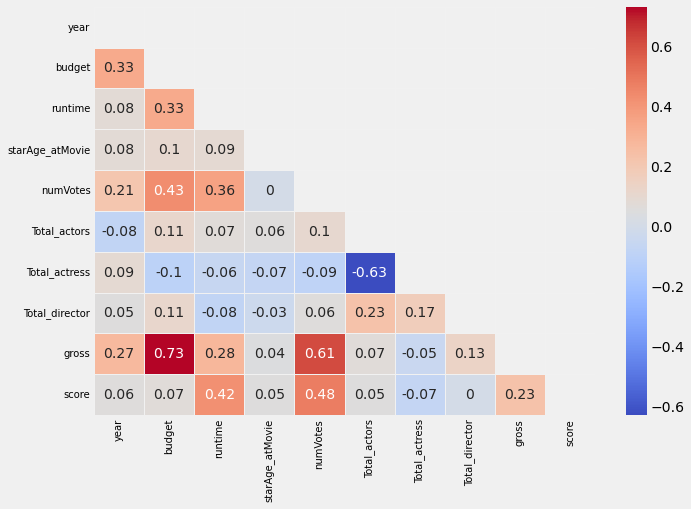

In [145]:
cor= df3[['year', 'budget', 'runtime', 'starAge_atMovie', 'numVotes',
       'Total_actors', 'Total_actress', 'Total_director', 'gross', 'score']]


plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (10,7)

# Corelation
corr = cor.corr().round(2)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# code to show only single corner heatmap
mask = np.zeros_like(corr,dtype=bool)
mask[np.triu_indices_from(mask)]=True
corr[mask]=np.nan
(corr.style.background_gradient(cmap='coolwarm',axis=None,vmin=-1,vmax=1)
 .highlight_null(null_color='#f1f1f1') 
 .set_precision(1))

#display corelation heatmap
sn.heatmap(corr,cmap="coolwarm",annot=True,linewidths=0.5,linecolor='#f1f1f1')
#print(plt.style.available)

<code style="background:yellow;color:black"><b><u><font size="5"> ** Outliers detection</font></u></b></code>

Lets Draw, Standarized Boxplots to detect extream values.

(array([-7.5, -5. , -2.5,  0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

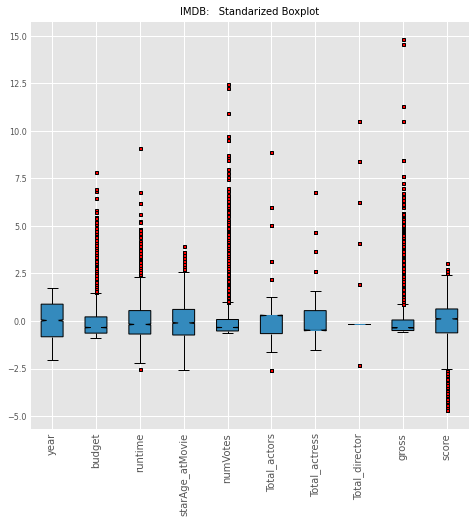

In [146]:
plt.style.use('ggplot')
attributeNames=cor.columns.tolist()
M=len(attributeNames)
red_box = dict(markerfacecolor='r', marker='s',markersize=3)
plt.figure(figsize=(7,7))
plt.title('IMDB:   Standarized Boxplot',fontsize=10)
plt.boxplot(zscore(cor), attributeNames,flierprops=red_box,patch_artist=True)
plt.xticks(range(1,M+1), attributeNames,fontsize=10, rotation=90) 
plt.yticks(fontsize=8)

All the values in our dataset are true. for example yes, some movies are extreamly high gross ammounts, we can not say its wrong. but for the sake of training a better model, we need to process some extream values.

from above box plot, we can say that, the attributes "NumVites" , "Total actors" , "total_directors", and "gross" has some extreamly values. 

lets also comfirm our doubt with the help of histogram.

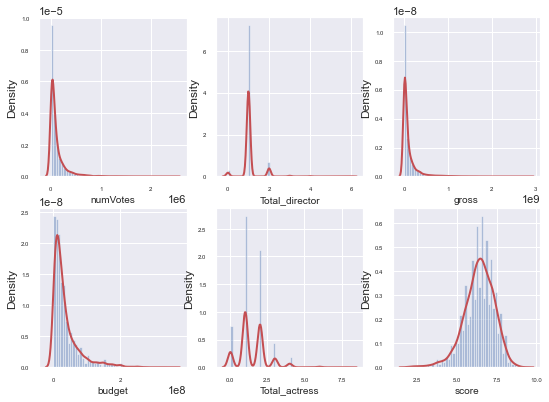

In [147]:
attributeNames=['numVotes', 'Total_director', 'gross', 'budget','Total_actress','score']
M=len(attributeNames)
plt.figure(figsize=(8,6))
u = np.floor(np.sqrt(M)); v = np.ceil(float(M)/u)
sn.set()
for i in range(M):
    attribute_Name = str(attributeNames[i])
    X = cor[attribute_Name]
    plt.subplot(int(u),int(v),i+1)
    ab=sn.distplot(X,kde_kws={"color": "r", "lw": 2})
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6) 
    ab.set_xlabel(attribute_Name,fontsize=10)
plt.show()


Intresting, it confirms that we have extream values in "gross", "budget", "NumVotes", "Total_actor". lets process them.

In [148]:
sts=df3[['budget','gross', 'Total_actors','Total_actress','numVotes', 'Total_director']]
sts.describe([.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.99]).astype(np.int64)

,budget,gross,Total_actors,Total_actress,numVotes,Total_director
count,5177,5177,5177,5177,5177,5177
mean,36037109,103591851,2,1,118635,1
std,40982859,185352749,1,0,189189,0
min,7000,309,0,0,236,0
1%,493999,126043,0,0,1285,0
10%,5000000,2835087,2,0,7078,1
20%,8000000,7966040,2,1,14943,1
30%,12000000,14638943,2,1,25173,1
40%,17000000,23503214,2,1,38008,1
50%,22000000,38075318,3,1,54291,1


<code style="background:yellow;color:black"><b><u><font size="5"> Fixing extream values (Cleaning)</font></u></b></code>

###### Functions defination

In [149]:
# NRW Function Working Shit
def max_quantile_replace(DF,attribute,quantile, replace=False):
    counts=0
    Max_thold=DF[attribute].quantile(quantile)
    print(quantile*100,' Percentile value for ',attribute,' = ',Max_thold)
    counts+=DF[DF[attribute]>Max_thold].shape[0]
    print('counts = ',counts)
    
    if replace==True:
        DF[attribute][DF[attribute]>Max_thold]=Max_thold
        print('Values replaced')
        return DF
################################################        
# Dataframe = DataFrame Name
# Attribute_name = String of attribute name
# Quantile = Quantile values between 0 and 1 (Float type value)
# replace = True if you want to replace values, False by default 
################################################

In [150]:
# Check this new Shit
def min_quantile_remove(DF, attribute,quantile, remove=False):
    counts=0
    Min_thold=DF[attribute].quantile(quantile)
    print(quantile*100,' Percentile value for ',attribute,' = ',Min_thold)
    counts+=DF[DF[attribute]<Min_thold].shape[0]
    print('counts = ',counts)
    
    if remove==True:
        DF=DF[DF[attribute]>Min_thold]
        print('Values Removed')
        return DF
################################################        
# Dataframe = DataFrame Name
# Attribute_name = String of attribute name
# Quantile = Quantile values between 0 and 1 (Float type value)
# remove = True if you want to remove values, False by default wont remove anything
################################################ 

<code style="background:yellow;color:black"><b><u><font size="5"> *** 1. Check Gross attribute </font></u></b></code>

In [151]:
df4_copy=df3.copy()  ######### Remove me at the end
# in case of issues
df3=df4_copy.copy()  ## Remove me at teh end

*>>> First of all lets remove entries with extremely small gross values, because these are controversial movies**

In [152]:
df3=min_quantile_remove(df3, 'gross',0.01, remove=True)

1.0  Percentile value for  gross  =  126043.0
counts =  52
Values Removed


*>>> Now lets check the extremely high values in gross and replace them with suitable quantile value**

In [153]:
df3=max_quantile_replace(df3,'gross',0.99, replace=True)

99.0  Percentile value for  gross  =  933087697.7600013
counts =  52
Values replaced


<code style="background:yellow;color:black"><b><u><font size="5"> *** 2. Check Number of votes for extream vlaues and replace theme </font></u></b></code>

In [154]:
df3=max_quantile_replace(df3,'numVotes',0.99, replace=True)

99.0  Percentile value for  numVotes  =  948829.0800000008
counts =  52
Values replaced


<code style="background:yellow;color:black"><b><u><font size="5"> *** 3. Check Runtime for extream vlaues and replace them </font></u></b></code>

In [155]:
df3=max_quantile_replace(df3,'runtime',0.996, replace=True)

99.6  Percentile value for  runtime  =  185.01599999999962
counts =  21
Values replaced


<code style="background:yellow;color:black"><b><u><font size="5"> *** 4. CheckBudget for extream vlaues and replace them </font></u></b></code>

In [156]:
df3=max_quantile_replace(df3,'budget',0.998, replace=True)

99.8  Percentile value for  budget  =  250000000.0
counts =  9
Values replaced


<code style="background:yellow;color:black"><b><u><font size="5"> *** 5. lets do the same for ['Total_actors','ctress','numVotes', 'director' </font></u></b></code>

In [157]:
list1=['Total_actors','Total_actress', 'Total_director']

for entry in list1:
    df3=max_quantile_replace(df3,entry,0.99, replace=True)
    

99.0  Percentile value for  Total_actors  =  6.0
counts =  17
Values replaced
99.0  Percentile value for  Total_actress  =  4.0
counts =  31
Values replaced
99.0  Percentile value for  Total_director  =  3.0
counts =  28
Values replaced


<code style="background:yellow;color:black"><b><u><font size="5"> *** 6. lets check score too, it seems it has some exreamly low values or extreamly high </font></u></b></code>

In [158]:
df3=min_quantile_remove(df3, 'score',0.001, remove=True) # Low values
df3=max_quantile_replace(df3,'score',0.999, replace=True) # High values

0.1  Percentile value for  score  =  2.2
counts =  4
Values Removed
99.9  Percentile value for  score  =  8.8
counts =  5
Values replaced


<code style="background:yellow;color:black"><b><u><font size="5"> >> Now lets check the correlation and box plots agian after above operations </font></u></b></code>

<AxesSubplot:>

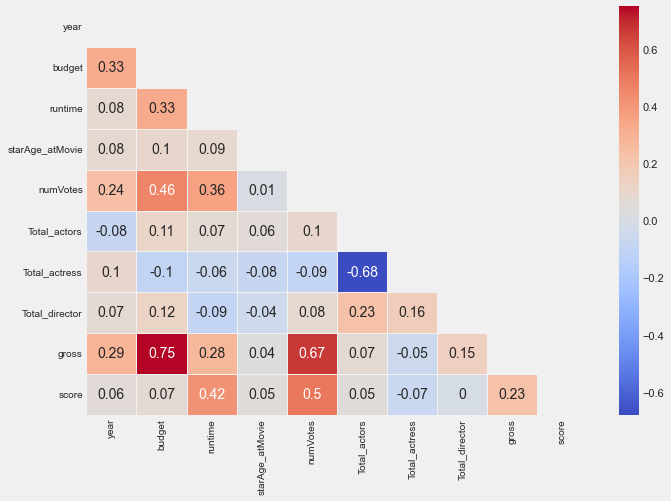

In [159]:
cor= df3[['year', 'budget', 'runtime', 'starAge_atMovie', 'numVotes',
       'Total_actors', 'Total_actress', 'Total_director', 'gross', 'score']]


plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (10,7)

# Corelation
corr = cor.corr().round(2)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# code to show only single corner heatmap
mask = np.zeros_like(corr,dtype=bool)
mask[np.triu_indices_from(mask)]=True
corr[mask]=np.nan
(corr.style.background_gradient(cmap='coolwarm',axis=None,vmin=-1,vmax=1)
 .highlight_null(null_color='#f1f1f1') 
 .set_precision(1))

#display corelation heatmap
sn.heatmap(corr,cmap="coolwarm",annot=True,linewidths=0.5,linecolor='#f1f1f1')
#print(plt.style.available)

(array([-6., -4., -2.,  0.,  2.,  4.,  6.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

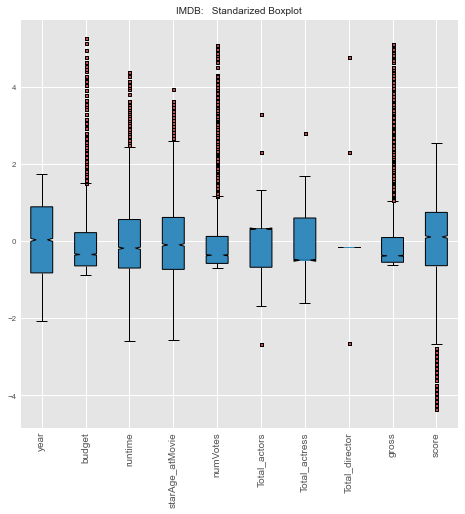

In [160]:
plt.style.use('ggplot')
attributeNames=cor.columns.tolist()
M=len(attributeNames)
red_box = dict(markerfacecolor='r', marker='s',markersize=3)
plt.figure(figsize=(7,7))
plt.title('IMDB:   Standarized Boxplot',fontsize=10)
plt.boxplot(zscore(cor), attributeNames,flierprops=red_box,patch_artist=True)
plt.xticks(range(1,M+1), attributeNames,fontsize=10, rotation=90) 
plt.yticks(fontsize=8)

extream value are comparitively much better, they are much packed then before and in order to maintain the data as orognla as possible, we should keep it relaxed when cleaning extream values. above box plot shows that its much better thn before. 

<code style="background:yellow;color:black"><b><font size="4">Now Our Data is cleaner thn before and its ready to select different attributes for modeling </font></b></code>

<code style="background:yellow;color:black"><b><u><font size="6">** Prediction Challenge:</font></u></b></code>

In [161]:
df3.to_csv('NB_3_result_IMDB_cleaned_data_11Nov.csv',index=False)

In [162]:
df= pd.read_csv('./NB_3_result_IMDB_cleaned_data_11Nov.csv')

<code style="background:yellow;color:black"><b><u><font size="6"> 1. Gross</font></u></b></code>

In [163]:
feature_variables_gross = ['title','year_group','continent', 'budget','runtime','numVotes', "Total_director"]
target_variable_gross = ['gross']

In [164]:
df_gross = df[feature_variables_gross].join(df[target_variable_gross])
df_gross.set_index('title', inplace=True)

In [165]:
df_gross_new = pd.get_dummies(df_gross, columns =["continent",'year_group'])

In [166]:
from sklearn.model_selection import train_test_split
y_gross=df_gross_new['gross']
x_gross=df_gross_new[:]
del x_gross['gross']

In [171]:
x_gross_train,x_gross_test, y_gross_train, y_gross_test=train_test_split(x_gross, y_gross, train_size=0.75,random_state=7)

In [172]:
# follow the usual sklearn pattern: import, instantiate, fit
from sklearn.linear_model import LinearRegression
lm_gross = LinearRegression()
lm_gross.fit(x_gross_train, y_gross_train)

LinearRegression()

In [173]:
print("R^2 for Linear Regression: %f" % lm_gross.score(x_gross_test, y_gross_test))
lm_gross_pred = lm_gross.predict(x_gross_test)

R^2 for Linear Regression: 0.726096


<code style="background:yellow;color:black"><b><u><font size="5">### K fold cross validation for LinearRegression model to predict Gross</font></u></b></code>

In [174]:
from sklearn.model_selection import cross_val_score
cross_val_score(LinearRegression(), x_gross, y_gross,cv=10)

array([0.38644338, 0.53183911, 0.61076683, 0.67766742, 0.5949799 ,
       0.63419818, 0.71669629, 0.71266069, 0.75729069, 0.67433469])

In [175]:
# menan value
sum(cross_val_score(LinearRegression(), x_gross, y_gross,cv=10))/10

0.6296877194731847

<code style="background:yellow;color:black"><b><u><font size="6"> 2. Score</font></u></b></code>

<code style="background:yellow;color:black"><b><u><font size="6">Score as Regression problem</font></u></b></code>

In [176]:
variables2=['titleId','budget','runtime','year_group','3_genres','numVotes','gross','score']
df2=df[variables2]
df2.set_index('titleId', inplace=True)

In [177]:
IMDB2=pd.get_dummies(df2, columns =['year_group','3_genres'])

In [178]:
IMDB2.head()

,budget,runtime,numVotes,gross,score,year_group_1980-1985,year_group_1986-1990,year_group_1991-1995,year_group_1996-2020,year_group_2001-2005,...,"3_genres_Horror,Sci-Fi,Thriller","3_genres_Horror,Thriller","3_genres_Mystery,Romance,Thriller","3_genres_Mystery,Sci-Fi,Thriller","3_genres_Mystery,Thriller","3_genres_Romance,Sci-Fi","3_genres_Romance,Sci-Fi,Thriller","3_genres_Sci-Fi,Thriller",3_genres_Thriller,3_genres_Western
titleId,,,,,,,,,,,,,,,,,,,,,
81505,19000000.0,146.0,948829.08,46998772.0,8.4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
80453,4500000.0,104.0,66580.00,58853106.0,5.8,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
80684,18000000.0,124.0,948829.08,538375067.0,8.7,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
80339,3500000.0,88.0,225610.00,83453539.0,7.7,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
80487,6000000.0,98.0,111580.00,39846344.0,7.3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [179]:
y_score=IMDB2['score']
x_score=IMDB2.copy()
del x_score['score']

In [180]:
from sklearn.model_selection import train_test_split
x_score_train,x_score_test, y_score_train, y_score_test=train_test_split(x_score, y_score, train_size=0.75,random_state=3)

In [181]:
from sklearn.linear_model import LinearRegression
lr_score = LinearRegression()
lr_score.fit(x_score_train, y_score_train)

# print intercept and coefficients
#print(lr_score.intercept_)
#print(lr_score.coef_)

LinearRegression()

In [182]:
print("R^2 for Linear Regression: %f" % lr_score.score(x_score_test, y_score_test))
lr_score_pred = lr_score.predict(x_score_test)

R^2 for Linear Regression: 0.453102


<code style="background:yellow;color:black"><b><u><font size="6">Score as Classification problem</font></u></b></code>

In [183]:
year=df2['score']
condition = [year<= 1, year<=2, year<=3, year<=4, year<=5, year<=6, year<=7, year <=8, year <=9, year <=10 ]
choice = ["0-1", "1-2", "2-3", "3-4", "4-5", "5-6", "6-7", "7-8","8-9","9-10"]
df2['score_label']=np.select(condition, choice)

In [184]:
df2.head()

,budget,runtime,year_group,3_genres,numVotes,gross,score,score_label
titleId,,,,,,,,
81505,19000000.0,146.0,1980-1985,"Drama,Horror",948829.08,46998772.0,8.4,8-9
80453,4500000.0,104.0,1980-1985,"Adventure,Drama,Romance",66580.00,58853106.0,5.8,5-6
80684,18000000.0,124.0,1980-1985,"Action,Adventure,Fantasy",948829.08,538375067.0,8.7,8-9
80339,3500000.0,88.0,1980-1985,Comedy,225610.00,83453539.0,7.7,7-8
80487,6000000.0,98.0,1980-1985,"Comedy,Sport",111580.00,39846344.0,7.3,7-8


In [185]:
IMDB3=pd.get_dummies(df2, columns =['year_group','3_genres'])

In [186]:
y_score=IMDB3['score_label']

x_score=IMDB3.copy()
del x_score['score']
del x_score['score_label']

In [187]:
from sklearn.model_selection import train_test_split
x_score_train,x_score_test, y_score_train, y_score_test=train_test_split(x_score, y_score, train_size=0.75,random_state=6)

## Apply differnt Classifier and validate using 10 Folds cross validation

In [188]:
# fit train function .... (to be used in final cleaned version of code)

def get_score(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

In [189]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

#####  1.LogisticRegression

In [190]:
print('/n/nMean Value : ',sum(cross_val_score(LogisticRegression(solver='liblinear',multi_class='ovr'), x_score, y_score,cv=10))/10)

/n/nMean Value :  0.46950334821428574


##### 2. SVM

In [191]:
print('/n/nMean Value : ',sum(cross_val_score(SVC(gamma='auto'), x_score, y_score,cv=10))/10)

/n/nMean Value :  0.43200525929549904


##### 4. Random Forest

In [192]:
print('/n/nMean Value : ',sum(cross_val_score(RandomForestClassifier(n_estimators=40),x_score, y_score,cv=10))/10)

/n/nMean Value :  0.5273582742172211


##### 5. Decision Tree 

In [193]:
print('/n/nMean Value : ',sum(cross_val_score(tree.DecisionTreeClassifier(),x_score, y_score,cv=10))/10)

/n/nMean Value :  0.47498929794520545


From above we now know that Random Forest is the best model for our dataset to predict score as calssification.

# Chosen Classification problem

In [194]:
# Random Forest
get_score(RandomForestClassifier(n_estimators=50), x_score_train,x_score_test, y_score_train, y_score_test)

0.58515625